importing the necessary libraries for the analysis. Numpy and pandas are imported for handling data structures, Dask for parallel computing, Matplotlib and Seaborn for data visualization, and Scipy for statistical analysis.

In [3]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy.stats as stats

# set up the environment
sns.set(style="darkgrid")
ProgressBar().register()

# Constants
SEED = 1
SAMPLE_RATE = 0.1
FILE_PATHS = [
    f"data/JC-2022{i:02d}-citibike-tripdata.csv" for i in range(1, 12)
] + ["data/JC-202112-citibike-tripdata.csv"]

# Function definitions
def preprocess_data(data):
    data = data.copy()
    data["started_at"] = dd.to_datetime(data["started_at"])
    data["ended_at"] = dd.to_datetime(data["ended_at"])
    
    data["started_at_year"] = data["started_at"].dt.year
    data["started_at_month"] = data["started_at"].dt.month
    data["started_at_day"] = data["started_at"].dt.day
    data["started_at_hour"] = data["started_at"].dt.hour
    data["started_at_minutes"] = data["started_at"].dt.minute
    data["started_at_seconds"] = data["started_at"].dt.second
    data["date_of_week"] = data["started_at"].dt.weekday
    
    return data

def load_and_preprocess_data(file_paths, sample_rate):
    data_arr = [
        dd.read_csv(file_path).sample(frac=sample_rate, random_state=SEED)
        for file_path in file_paths
    ]
    data = dd.concat(data_arr)
    data = preprocess_data(data)
    
    return data

data = load_and_preprocess_data(FILE_PATHS, SAMPLE_RATE)
data_length = data.count().compute()


[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.3s


In [4]:
#Analyzing the duration of rides
data["duration"] = data["ended_at"] - data["started_at"]
data["duration_seconds"] = data["duration"].dt.total_seconds()

data.compute()
data.to_csv("data_with_duration.csv", index=False)

[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.6s


['/home/sb8389_nyu_edu/Project/Old/data_with_duration.csv/00.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_duration.csv/01.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_duration.csv/02.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_duration.csv/03.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_duration.csv/04.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_duration.csv/05.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_duration.csv/06.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_duration.csv/07.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_duration.csv/08.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_duration.csv/09.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_duration.csv/10.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_duration.csv/11.part']

Casual users have an average duration of approximately 1753.11 seconds (around 29.22 minutes) and member users have an average duration of about 755.80 seconds (around 12.6 minutes). From this insight, we can infer that casual users tend to have longer bike rides compared to members.

In [5]:
duration_by_member_type = data.groupby("member_casual")["duration_seconds"].mean().compute()
print("Average duration by member type:", duration_by_member_type)

[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.4s
Average duration by member type: member_casual
casual    1753.108287
member     755.798614
Name: duration_seconds, dtype: float64


In [6]:
print("Average Duration of Rides by User Type")
for i,val in enumerate(duration_by_member_type.index):
    print(val,  ": " , duration_by_member_type.values)
    
print("col 1:User Type")
print("cold 2: Average Duration (Seconds)")

Average Duration of Rides by User Type
casual :  [1753.10828744  755.79861408]
member :  [1753.10828744  755.79861408]
col 1:User Type
cold 2: Average Duration (Seconds)


The plot allows for a visual comparison between casual users and members, showing that casual users tend to have longer ride durations.

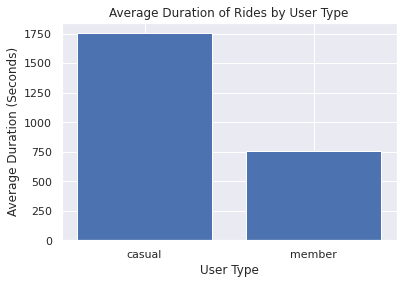

In [7]:
plt.bar(duration_by_member_type.index, duration_by_member_type.values)
plt.xlabel("User Type")
plt.ylabel("Average Duration (Seconds)")
plt.title("Average Duration of Rides by User Type")
plt.show()

In [9]:
start_stations_count = data["start_station_name"].value_counts().compute()
end_stations_count = data["end_station_name"].value_counts().compute()

[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.3s


This output lists the top 10 most popular start stations and their corresponding number of rides. Analyzing the most popular start stations helps identify areas with high demand for bikes, which can inform decisions about station locations, bike allocation, and maintenance schedules.

In [10]:
print("Top 10 Start Stations")
for i,val in enumerate(start_stations_count.head(10).index):
    print(val,  ": " , start_stations_count.head(10).values)
    
print("col 1:Start Station")
print("cold 2: Number of Rides")

Top 10 Start Stations
Grove St PATH :  [4271 3345 3215 2996 2324 2186 2050 2046 1991 1925]
South Waterfront Walkway - Sinatra Dr & 1 St :  [4271 3345 3215 2996 2324 2186 2050 2046 1991 1925]
Hoboken Terminal - River St & Hudson Pl :  [4271 3345 3215 2996 2324 2186 2050 2046 1991 1925]
Hoboken Terminal - Hudson St & Hudson Pl :  [4271 3345 3215 2996 2324 2186 2050 2046 1991 1925]
City Hall - Washington St & 1 St :  [4271 3345 3215 2996 2324 2186 2050 2046 1991 1925]
Newport Pkwy :  [4271 3345 3215 2996 2324 2186 2050 2046 1991 1925]
Newport PATH :  [4271 3345 3215 2996 2324 2186 2050 2046 1991 1925]
Hamilton Park :  [4271 3345 3215 2996 2324 2186 2050 2046 1991 1925]
Hoboken Ave at Monmouth St :  [4271 3345 3215 2996 2324 2186 2050 2046 1991 1925]
Marin Light Rail :  [4271 3345 3215 2996 2324 2186 2050 2046 1991 1925]
col 1:Start Station
cold 2: Number of Rides


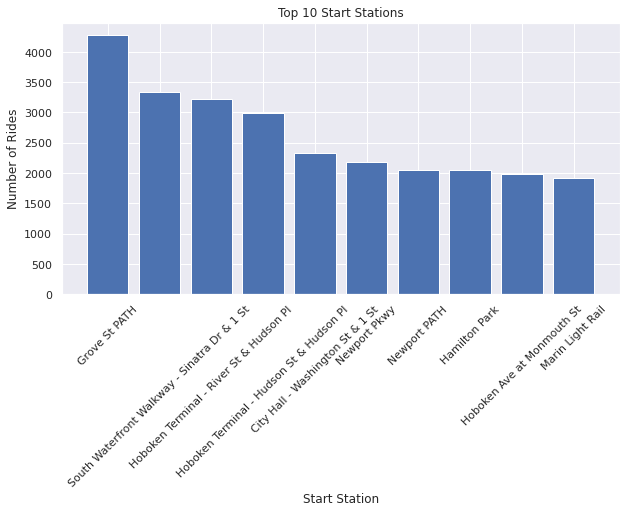

In [6]:
plt.figure(figsize=(10, 5))
plt.bar(start_stations_count.head(10).index, start_stations_count.head(10).values)
plt.xlabel("Start Station")
plt.ylabel("Number of Rides")
plt.title("Top 10 Start Stations")
plt.xticks(rotation=45)
plt.show()

This output lists the top 10 most popular end stations and their corresponding number of rides. Analyzing the most popular end stations provides insights into areas with high bike drop-off rates, which can help optimize bike redistribution and station maintenance.

In [11]:
print("Top 10 End Stations")
for i,val in enumerate(end_stations_count.head(10).index):
    print(val,  ": " , end_stations_count.head(10).values)
    
print("col 1: End Station")
print("cold 2: Number of Rides")

Top 10 End Stations
Grove St PATH :  [4440 3493 3214 3045 2292 2166 2110 2039 2013 1929]
South Waterfront Walkway - Sinatra Dr & 1 St :  [4440 3493 3214 3045 2292 2166 2110 2039 2013 1929]
Hoboken Terminal - River St & Hudson Pl :  [4440 3493 3214 3045 2292 2166 2110 2039 2013 1929]
Hoboken Terminal - Hudson St & Hudson Pl :  [4440 3493 3214 3045 2292 2166 2110 2039 2013 1929]
City Hall - Washington St & 1 St :  [4440 3493 3214 3045 2292 2166 2110 2039 2013 1929]
Newport Pkwy :  [4440 3493 3214 3045 2292 2166 2110 2039 2013 1929]
Hamilton Park :  [4440 3493 3214 3045 2292 2166 2110 2039 2013 1929]
Hoboken Ave at Monmouth St :  [4440 3493 3214 3045 2292 2166 2110 2039 2013 1929]
Newport PATH :  [4440 3493 3214 3045 2292 2166 2110 2039 2013 1929]
Marin Light Rail :  [4440 3493 3214 3045 2292 2166 2110 2039 2013 1929]
col 1: End Station
cold 2: Number of Rides


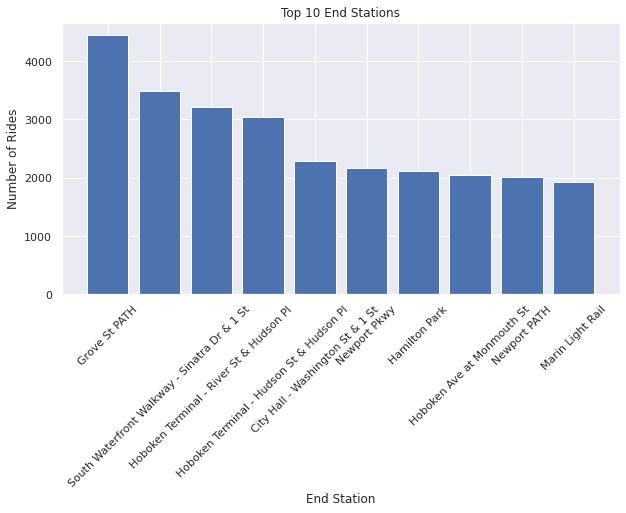

In [7]:
plt.figure(figsize=(10, 5))
plt.bar(end_stations_count.head(10).index, end_stations_count.head(10).values)
plt.xlabel("End Station")
plt.ylabel("Number of Rides")
plt.title("Top 10 End Stations")
plt.xticks(rotation=45)
plt.show()

In [8]:
# Analyzing the ride distances
def haversine(lat1, lon1, lat2, lon2):
    R = 6371 # Radius of the Earth in km
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c


In [9]:
data["distance_km"] = data.map_partitions(lambda df: haversine(df["start_lat"], df["start_lng"], df["end_lat"], df["end_lng"]),meta=("float64"))
data.compute()
data.to_csv("data_with_distance.csv", index=False)

[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  5.6s


['/home/sb8389_nyu_edu/Project/Old/data_with_distance.csv/00.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_distance.csv/01.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_distance.csv/02.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_distance.csv/03.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_distance.csv/04.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_distance.csv/05.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_distance.csv/06.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_distance.csv/07.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_distance.csv/08.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_distance.csv/09.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_distance.csv/10.part',
 '/home/sb8389_nyu_edu/Project/Old/data_with_distance.csv/11.part']

Casual users have an average ride distance of 1.27 km, while member users have an average ride distance of 1.11 km. This insight suggests that casual users tend to ride slightly longer distances than member users.

In [10]:
average_distance_by_member_type = data.groupby("member_casual")["distance_km"].mean().compute()
print("Average distance by member type:", average_distance_by_member_type)

[########################################] | 100% Completed |  3.4s
Average distance by member type: member_casual
casual    1.266071
member    1.110763
Name: distance_km, dtype: float64


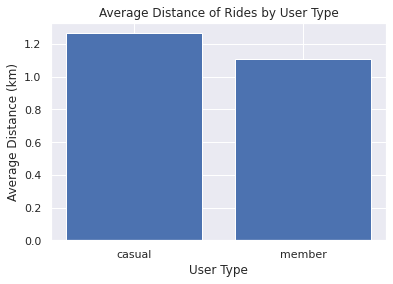

In [11]:
plt.bar(average_distance_by_member_type.index, average_distance_by_member_type.values)
plt.xlabel("User Type")
plt.ylabel("Average Distance (km)")
plt.title("Average Distance of Rides by User Type")
plt.show()